In [ ]:
!pip install kornia advertorch
!nvidia-smi

     |████████████████████████████████| 225kB 4.3MB/s 
     |████████████████████████████████| 5.7MB 12.4MB/s 
  Created wheel for advertorch: filename=advertorch-0.2.3-cp36-none-any.whl size=5696220 sha256=21bbbe55e3444d31b81e22587635a9530560b14d32606a807fc22298c85f91bb
  Stored in directory: /root/.cache/pip/wheels/9b/53/6e/6b2509701b0da68443fa3d4499733f5455d6d583afa8c46676
Successfully built advertorch
Wed Jan  6 12:47:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torchvision.utils import make_grid
from torchsummary import summary

from advertorch.attacks import GradientSignAttack,GradientAttack,LinfPGDAttack

import time
import kornia
import numpy as np
from numba import njit
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
"""
TODO:

- Probability of dropping to be found from secret key, not set it by default.
- Use list for deciding sizes of layers, changing numbers each time is cumbersome.
- Make a Github repo and push changes to track them easily.
- Design Question: Fix Neuron sizes before hand? or initialize layers and then zero them out? Memory? Privacy?
- Inbuilt torch functions instead of custom calls? einsums?
- Adversarial Robustness Evaluations: Black, Grey, White?
  - BlackBox attacks : Ensembling?

"""

class RandomNet(nn.Module):

    def __init__(self,one_time_random=True, dev='cuda'):
      super(RandomNet, self).__init__()

      self.linear1 = nn.Linear(784,512)
      self.relu1 = nn.ReLU()
      self.linear2 = nn.Linear(512,256)
      self.relu2 = nn.ReLU()
      self.linear3 = nn.Linear(256,64)
      self.relu3 = nn.ReLU()
      self.linear4 = nn.Linear(64, 10)

      self.mat1 = self.rand_drop(512,dev)
      self.mat2 = self.rand_drop(256,dev)
      self.mat3 = self.rand_drop(64,dev)

      self.one_time_random = one_time_random
      self.dev = dev

    def rand_drop(self, sz, dev = 'cuda', p=0.8):

      x = torch.rand(1,sz)
      x = (x <= p).type(torch.IntTensor)
      return x.to(dev)

    def forward(self, x):
      # print(f"Shape before {x.shape}")
      if self.one_time_random == False:

        self.mat1 = self.rand_drop(512,self.dev)
        self.mat2 = self.rand_drop(256,self.dev)
        self.mat3 = self.rand_drop(64,self.dev)

      x = self.relu1(self.linear1(x))*(self.mat1)
      # print(f"Shape after layer1 {x.shape} {self.mat1.device}")
      print(f"neurons shutoff in layer1 {(self.mat1==0).sum()} out of {self.mat1.shape[1]}")
      x = self.relu2(self.linear2(x))*(self.mat2)
      # print(f"Shape after layer2 {x.shape}")
      print(f"neurons shutoff in layer2 {(self.mat2==0).sum()} out of {self.mat2.shape[1]}")
      x = self.relu3(self.linear3(x))*(self.mat3)
      # print(f"Shape after layer3 {x.shape}")
      print(f"neurons shutoff in layer3 {(self.mat3==0).sum()} out of {self.mat3.shape[1]}")
      x = (self.linear4(x))
      # print(f"Shape after layer4 {x.shape}")
      return x

In [ ]:
#Hyperparameters

device = 'cuda'
train_batch_size =128
test_batch_size = 64
test_batch_test_all = 10000
epochs = 15
learning_rate = 3e-4
weight_decay =  0

In [ ]:
train_dataset = datasets.MNIST(root='../data/',train=True, download=True, 
    transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=train_batch_size, shuffle=True)

test_dataset = datasets.MNIST(root='../data/', train=False, download=True, 
    transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, 
    batch_size=test_batch_size, shuffle=True)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


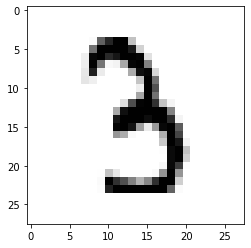

In [ ]:
"""
rudimentary tests
 """
for X_train, y_train in train_loader:
  X_train = X_train.to(device)
  X_train = X_train.reshape(train_batch_size,-1)
  break
plt.imshow(X_train[2].reshape(28,28).squeeze().cpu(),cmap="Greys")

In [ ]:
model_one_rand = RandomNet(one_time_random=True , dev = device) #Fix neurons to be shutoff
model_one_rand.to(device)
criterion_one_rand = nn.CrossEntropyLoss() 
optimizer_one_rand = torch.optim.Adam(model_one_rand.parameters(),lr=learning_rate)

model_mult_rand = RandomNet(one_time_random=False , dev = device) #Don't fix neurons to be shutoff 
model_mult_rand.to(device)
criterion_mult_rand = nn.CrossEntropyLoss() 
optimizer_mult_rand = torch.optim.Adam(model_mult_rand.parameters(),lr=learning_rate)

In [ ]:
print('for one time random\n')
model_one_rand.forward(X_train)

print('\nfor multi time random\n')
model_mult_rand(X_train);

for one time random

neurons shutoff in layer1 111 out of 512
neurons shutoff in layer2 48 out of 256
neurons shutoff in layer3 13 out of 64

for multi time random

neurons shutoff in layer1 106 out of 512
neurons shutoff in layer2 67 out of 256
neurons shutoff in layer3 13 out of 64


In [ ]:
#FOR LOOP EPOCHS
#train the model
import time
start_time = time.time()


#VARIABLES,TRACKERS
for i in range(epochs):

  for j,(X_train,y_train) in enumerate(train_loader):
    
    j+=1

    #TRAIN
    X_train = X_train.to(device).reshape(X_train.shape[0],-1)
    y_train = y_train.to(device)
    
    y_pred = model_one_rand(X_train)
    loss_one_rand = criterion_one_rand(y_pred,y_train)

    optimizer_one_rand.zero_grad()
    loss_one_rand.backward()
    optimizer_one_rand.step()

    y_pred = model_mult_rand(X_train)
    loss_mult_rand = criterion_mult_rand(y_pred,y_train)

    optimizer_mult_rand.zero_grad()
    loss_mult_rand.backward()
    optimizer_mult_rand.step()

    if j% 250== 0:
      print(f'epoch {i} : batch  {j} : loss one rand {loss_one_rand.item()} : Loss Mult rand : {loss_mult_rand.item()}')
      #plt.imshow(X_train[5].squeeze().cpu(),cmap="Greys")
      
current_time = time.time()
print(f'the model took {(current_time-start_time)/60} minutes to train')

epoch 0 : batch  250 : loss one rand 0.3026416003704071 : Loss Mult rand : 0.5672222375869751
epoch 1 : batch  250 : loss one rand 0.23694980144500732 : Loss Mult rand : 0.274746298789978
epoch 2 : batch  250 : loss one rand 0.17469871044158936 : Loss Mult rand : 0.21091534197330475
epoch 3 : batch  250 : loss one rand 0.17559684813022614 : Loss Mult rand : 0.2433175891637802
epoch 4 : batch  250 : loss one rand 0.18005216121673584 : Loss Mult rand : 0.15587842464447021
epoch 5 : batch  250 : loss one rand 0.08314592391252518 : Loss Mult rand : 0.15622568130493164
epoch 6 : batch  250 : loss one rand 0.07096317410469055 : Loss Mult rand : 0.10718517005443573
epoch 7 : batch  250 : loss one rand 0.13596351444721222 : Loss Mult rand : 0.1636575311422348
epoch 8 : batch  250 : loss one rand 0.0721372663974762 : Loss Mult rand : 0.14850746095180511
epoch 9 : batch  250 : loss one rand 0.03985688090324402 : Loss Mult rand : 0.038087163120508194
epoch 10 : batch  250 : loss one rand 0.029246

Test accuracy Basic: 9791/10000 =  97.910%


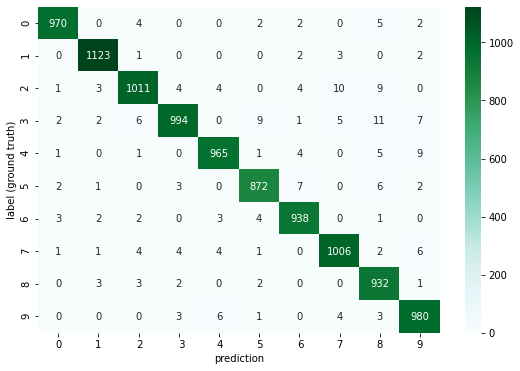

In [ ]:
test_load_all = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_test_all, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:

        X_test = X_test.to(device).reshape(X_test.shape[0],-1)
        y_test = y_test.to(device)
        y_val = model_one_rand(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

        break
        
print(f'Test accuracy Basic: {correct.item()}/{test_batch_test_all} = {correct.item()*100/(test_batch_test_all):7.3f}%')

class_names = ['0', '1', ' 2', '  3', ' 4', ' 5', ' 6', '7', '8', '9']
arr = confusion_matrix(predicted.view(-1).cpu(), y_test.view(-1).cpu())
df_cm = pd.DataFrame(arr, class_names, class_names)


plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

Test accuracy Basic: 9794/10000 =  97.940%


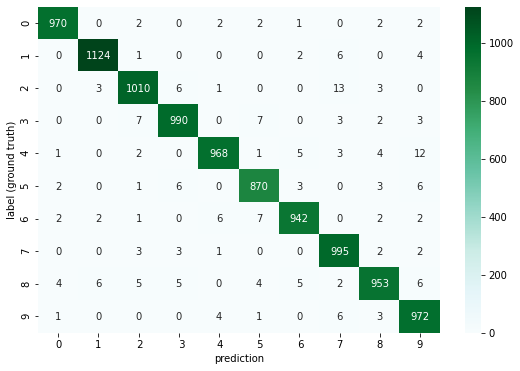

In [ ]:
test_load_all = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_test_all, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:

        X_test = X_test.to(device).reshape(X_test.shape[0],-1)
        y_test = y_test.to(device)
        y_val = model_mult_rand(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

        break
        
print(f'Test accuracy Basic: {correct.item()}/{test_batch_test_all} = {correct.item()*100/(test_batch_test_all):7.3f}%')

class_names = ['0', '1', ' 2', '  3', ' 4', ' 5', ' 6', '7', '8', '9']
arr = confusion_matrix(predicted.view(-1).cpu(), y_test.view(-1).cpu())
df_cm = pd.DataFrame(arr, class_names, class_names)


plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()